# Implementing Soft-Actor-Critic V2  (no Value network)
(https://arxiv.org/abs/1812.05905)
### References: 
OpenAI Gym <br/>
https://github.com/ajaysub110/sac-pytorch

In [9]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
import gym
import random
import pandas as pd
import importlib
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import torch.distributions as tdist
import torch.optim as opt
from collections import deque


In [10]:
TAU = 0.005
EPSILON = 1e-6
H_DIM = 15
LR = 3e-4
REPLAY_MEMORY_SIZE = 50000
ALPHA = 1.0
GAMMA = 0.99 # 0.98
ENTROPY_TUNING = True # True
MIN_LOG = -20
MAX_LOG = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
#HElper
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
def copy_params(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def soft_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

In [12]:
class ReplayMemory:
    def __init__(self,size):
        self.size = size
        self.memory = deque([],maxlen=size)

    def push(self, x):
        self.memory.append(x)
    
    def sample(self, batch_size):
        if(batch_size <= self.get_len()):
            batch = random.sample(self.memory,batch_size)
            state,action,reward,next_state,done = map(np.stack, zip(*batch))
            return state, action, reward, next_state, done
        return None, None, None, None, None

    def get_len(self):
        return len(self.memory)

In [13]:
import csv
import numpy as np
from scipy.optimize import minimize
import os


def price_signal(day = 45):

    """
    Utkarsha's work on price signal from a building with demand and solar

    Input: Day = an int signifying a 24 hour period. 365 total, all of 2012, start at 1.
    Output: netdemand_price, a measure of how expensive energy is at each time in the day
        optionally, we can return the optimized demand, which is the building
        calculating where the net demand should be allocated
    """

    pv = np.array([])
    price = np.array([])
    demand = np.array([])
    baselines_path = os.path.split(os.getcwd())[0]
    data_path = os.path.join(baselines_path, "behavioral_sim", "building_data.csv")
    with open(data_path, encoding='utf8') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader,None)
        rowcount = 0
        for row in csvreader:
            pv = np.append(pv, 0.001*float(row[3])) # Converting Wh to kWh
            price = np.append(price, float(row[2])) # Cost per kWh
            val = row[5]
            if val in (None,""): #How to treat missing values
                val = 0
            else:
                val = float(val) # kWh
            demand = np.append(demand, val)
            rowcount+=1
            # if rowcount>100:
            #     break

    pvsize = 5 #Assumption

    netdemand = demand.copy()
    for i in range(len(demand)):
        netdemand[i] = demand[i] - pvsize*pv[i]

    # Data starts at 5 am on Jan 1
    netdemand_24 = netdemand[24*day-5:24*day+19]
    price_24 = price[24*day-5:24*day+19]
    pv_24 = pv[24*day-5:24*day+19]
    demand_24 = demand[24*day-5:24*day+19]

    # Calculate optimal load scheduling. 90% of load is fixed, 10% is controllable.
    def optimise_24h(netdemand_24, price_24):
        currentcost = netdemand_24*price_24

        fixed_load = 0.9*netdemand_24
        controllable_load = sum(0.1*netdemand_24)
        # fixed_load = 0*netdemand_24
        # controllable_load = sum(netdemand_24)

        def objective(x):
            load = fixed_load + x
            cost = np.multiply(price_24,load)
            # Negative demand means zero cost, not negative cost
            # Adding L1 regularisation to penalise shifting of occupant demand
            lambd = 0.005
            return sum(np.maximum(cost,0)) + lambd*sum(abs(x-0.1*netdemand_24))

        def constraint_sumofx(x):
            return sum(x) - controllable_load

        def constraint_x_positive(x):
            return x

        x0 = np.zeros(24)
        cons = [
            {'type':'eq', 'fun': constraint_sumofx},
            {'type':'ineq', 'fun':constraint_x_positive}
        ]
        sol = minimize(objective, x0, constraints=cons)
        return sol

    sol = optimise_24h(netdemand_24,price_24)
    x = sol['x']

    netdemand_price_24 = netdemand_24*price_24

    return(netdemand_price_24)

In [14]:
import cvxpy as cvx
import osqp
import numpy as np

#### file to calculate the rewards. Meant to be modular: 
#### class Rewards should have several different functions by Dec 2019


class Reward():
	def __init__(self, energy_use, prices, min_demand, max_demand):
		"""
		Args: 
			energy_use: list returned by Person class signifying energy use 
			prices: list returned by grid signifying cost throughout day 
			min_demand: value computed by Person class signifying minimum energy use long term
			max_demand: value computed by Person class signifying maximum energy use long term
		"""

		self.energy_use = np.array(energy_use)
		self.prices = np.array(prices) 
		self._num_timesteps = energy_use.shape[0]
		self.min_demand = min_demand
		self.max_demand = max_demand
		self.total_demand = np.sum(energy_use)

	def ideal_use_calculation(self):
		"""
		Computes an optimization of demand according to price 

		returns: np.array of ideal energy demands given a price signal 
		"""

		demands = cvx.Variable(self._num_timesteps)
		min_demand = cvx.Parameter()
		max_demand = cvx.Parameter()
		total_demand = cvx.Parameter()
		prices = cvx.Parameter(self._num_timesteps)

		min_demand = self.min_demand
		max_demand = self.max_demand
		total_demand = self.total_demand
		prices = self.prices
		constraints = [cvx.sum(demands, axis=0, keepdims=True) == total_demand]
		# constraints = [np.ones(self._num_timesteps).T * demands == total_demand]
		for i in range(self._num_timesteps):
			constraints += [demands[i] <= max_demand]
			constraints += [min_demand <= demands[i]]	


		objective = cvx.Minimize(demands.T * prices)
		problem = cvx.Problem(objective, constraints)

		problem.solve(solver = cvx.OSQP, verbose=False)
		return np.array(demands.value)

	def neg_distance_from_ideal(self, demands):
		"""
		args: 
			demands: np.array() of demands from ideal_use_calculation()

		returns: 
			a numerical distance metric, negated
		"""

		return -((demands - self.energy_use)**2).sum()

	def cost_distance(self, ideal_demands):
		"""
		args: 
			demands: np.array() of demands from ideal_use_calculation()

		returns: 
			a cost-based distance metric, negated
		"""
		current_cost = np.dot(self.prices, self.energy_use)
		ideal_cost = np.dot(self.prices, ideal_demands)

		cost_difference = ideal_cost - current_cost
		
		return cost_difference

	def log_cost_distance(self, ideal_demands):
		"""
		args: 
			demands: np.array() of demands from ideal_use_calculation()

		returns: 
			the log of the cost distance
		"""
		current_cost = np.dot(self.prices, self.energy_use)
		ideal_cost = np.dot(self.prices, ideal_demands)

		cost_difference = ideal_cost - current_cost
		
		#TODO ENSURE THAT COST DIFFERENCE IS < 0
		if cost_difference < 0: 
			return -np.log(-cost_difference)
		else:
			print("WEIRD REWARD ALERT. IDEAL COST >= CURRENT COST. returning reward of 10")
			return 10

	def scaled_cost_distance(self, ideal_demands):
		"""
		args: 
			demands: np.array() of demands from ideal_use_calculation()

		returns: 
			a cost-based distance metric normalized by total ideal cost
		"""
		current_cost = np.dot(self.prices, self.energy_use)
		ideal_cost = np.dot(self.prices, ideal_demands)

		cost_difference = ideal_cost - current_cost
		
		return cost_difference/ideal_cost


In [15]:
import pandas as pd
import numpy as np

#### file to make the simulation of people that we can work with 


class Person():
    """ Person (parent?) class -- will define how the person takes in a points signal and puts out an energy signal 
    baseline_energy = a list or dataframe of values. This is data from SinBerBEST 
    points_multiplier = an int which describes how sensitive each person is to points 

    """

    def __init__(self, baseline_energy_df, points_multiplier = 1):
        self.baseline_energy_df = baseline_energy_df
        self.baseline_energy = np.array(self.baseline_energy_df["net_energy_use"])
        self.points_multiplier = points_multiplier

        baseline_min = self.baseline_energy.min()
        baseline_max = self.baseline_energy.max()
        baseline_range = baseline_max - baseline_min

        self.min_demand = np.maximum(0, baseline_min + baseline_range * .05)
        self.max_demand = np.maximum(0, baseline_min + baseline_range * .95)


    def energy_output_simple_linear(self, points):
        """Determines the energy output of the person, based on the formula:

        y[n] = -sum_{rolling window of 5} points + baseline_energy + noise

        inputs: points - list or dataframe of points values. Assumes that the 
        list will be in the same time increment that energy_output will be. 

        For now, that's in 1 hour increments

        """
        points_df = pd.DataFrame(points)

        points_effect = (
            points_df
                .rolling(
                        window = 5,
                        min_periods = 1)
                .mean()
            )



        time = points_effect.shape[0]
        energy_output= []

        for t in range(time):
            temp_energy = self.baseline_energy[t] - points_effect.iloc[t]*self.points_multiplier + \
                np.random.normal(1)
            energy_output.append(temp_energy)

        return pd.DataFrame(energy_output)

    def pure_linear_signal(self, points, baseline_day=0):
        """
        A linear person. The more points you give them, the less energy they will use
        (within some bounds) for each hour. No rolling effects or anything. The simplest
        signal. 
        """

        # hack here to always grab the first day from the baseline_energy
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]

        points_effect = np.array(points * self.points_multiplier)
        output = output - points_effect

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)
        return output



    def get_min_demand(self):
        return self.min_demand
        # return np.quantile(self.baseline_energy, .05)

    def get_max_demand(self):
        return self.max_demand
        # return np.quantile(self.baseline_energy, .95)

class Person_with_hysteresis(Person):
    """ Wendy -- Determines the energy output of the person, based on the formula:

        y[n] = f(points) + baseline_energy + noise

        f: super special secret function that Wendy designs with hysteresis 

        inputs: points - list or dataframe of points values. Assumes that the 
        list will be in the same time increment that energy_output will be. 

        For now, that's in 5 minute increments"""

    def __init__(self, baseline_energy, points_multiplier = 1):
        pass


class FixedDemandPerson(Person):

    def __init__(self, baseline_energy_df, points_multiplier = 1):
        super().__init__(baseline_energy_df, points_multiplier)


    def demand_from_points(self, points, baseline_day=0):
        # hack here to always grab the first day from the baseline_energy
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
        total_demand = np.sum(output)


        points_effect = np.array(points * self.points_multiplier)
        output = output - points_effect

        # scale to keep total_demand (almost) constant
        # almost bc imposing bounds afterwards
        output = output * (total_demand/np.sum(output))

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)

        return output

    def adverserial_linear(self, points, baseline_day=0):
        # hack here to always grab the first day from the baseline_energy
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
        total_demand = np.sum(output)


        points_effect = np.array(points * self.points_multiplier)
        output = output + points_effect

        # scale to keep total_demand (almost) constant
        # almost bc imposing bounds afterwards
        output = output * (total_demand/np.sum(output))

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)

        return output

class DeterministicFunctionPerson(Person):

    def __init__(self, baseline_energy_df, points_multiplier = 1):
        super().__init__(baseline_energy_df, points_multiplier)

    def threshold_response_func(self, points):
        points = np.array(points) * self.points_multiplier
        threshold = np.mean(points)
        return [p if p>threshold else 0 for p in points]

    def exponential_response_func(self, points):
        points = np.array(points) * self.points_multiplier
        points_effect = [p**2 for p in points]

        return points_effect

    def sin_response_func(self,points):
        points = np.array(points) 
        # n = np.max(points)
        # points = [np.sin((float(i)/float(n))*np.pi) for i in points]	
        points = [np.sin(float(i)*np.pi)*self.points_multiplier for i in points]	
        points = points 
        return points

    def routine_output_transform(self, points_effect, baseline_day=0):
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
        total_demand = np.sum(output)

        # scale to keep total_demand (almost) constant
        # almost bc imposing bounds afterwards
        output = output - points_effect
        output = output * (total_demand/np.sum(output))

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)
        return output

    def threshold_response(self, points):
        points_effect = self.threshold_response_func(points)
        output = self.routine_output_transform(points_effect)
        return output

    def sin_response(self, points):
        points_effect = self.sin_response_func(points)
        output = self.routine_output_transform(points_effect)
        return output

    def exp_response(self, points):
        points_effect = self.exponential_response_func(points)
        output = self.routine_output_transform(points_effect)
        return output

    def threshold_exp_response(self,points):
        points_effect = self.exponential_response_func(points)
        points_effect = self.threshold_response_func(points_effect)
        output = self.routine_output_transform(points_effect)
        return output

    def linear_response(self, points):
        points_effect = points*self.points_multiplier
        output = self.routine_output_transform(points_effect)
        return output





In [98]:
from gym import spaces
class BehavSimEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, one_day=False, energy_in_state=False):
        super(BehavSimEnv, self).__init__()

        self.action_space = spaces.Box(low=0, high=10, shape=(10,), dtype=np.float32)
        if energy_in_state:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32)
        else:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32)

        self.one_day = one_day
        self.energy_in_state = energy_in_state
        self.prices = self._get_prices(one_day)
        assert self.prices.shape == (365, 10)

        self.player_dict = self._create_agents()
        self.cur_iter = 0
        self.day = 0
        print("BehavSimEnv Initialized")


    def _get_prices(self, one_day):
        
        all_prices = []
        if one_day:
            # if repeating the same day, then use a random day. 
            # SET FIXED DAY HERE
            day = 50
            price = price_signal(day + 1)
            price = np.array(price[8:18])
            for i in range(365):
                all_prices.append(price)
        else:
            day = 0
            for i in range(365):  
                price = price_signal(day + 1)
                price = np.array(price[8:18])
                # put a floor on the prices so we don't have negative prices
                price = np.maximum([0.01], price)
                all_prices.append(price)
                day += 1

        return np.array(all_prices)

    def _create_agents(self):
        """Initialize the market agents
            Args:
              None

            Return:
              agent_dict: dictionary of the agents
        """

        # TODO: This needs to be updated

        # Skipping rows b/c data is converted to PST, which is 16hours behind
        # so first 10 hours are actually 7/29 instead of 7/30
        
        # baseline_energy1 = convert_times(pd.read_csv("wg1.txt", sep = "\t", skiprows=range(1, 41)))
        # baseline_energy2 = convert_times(pd.read_csv("wg2.txt", sep = "\t", skiprows=range(1, 41)))
        # baseline_energy3 = convert_times(pd.read_csv("wg3.txt", sep = "\t", skiprows=range(1, 41)))

        # be1 = change_wg_to_diff(baseline_energy1)
        # be2 = change_wg_to_diff(baseline_energy2)
        # be3 = change_wg_to_diff(baseline_energy3)

        player_dict = {}

        # I dont trust the data at all
        # helper comment         [0, 1, 2, 3, 4, 5,  6,  7,  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18, 19, 20,  21, 22, 23]
        sample_energy = np.array([0, 0, 0, 0, 0, 0, 20, 50, 80, 120, 200, 210, 180, 250, 380, 310, 220, 140, 100, 50, 20,  10,  0,  0])

        #only grab working hours (8am - 6pm)
        working_hour_energy = sample_energy[8:18]

        my_baseline_energy = pd.DataFrame(data={"net_energy_use": working_hour_energy})

        player_dict['player_0'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_1'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_2'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_3'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_4'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_5'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_6'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_7'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)

        return player_dict

    def step(self, action):
        prev_observation = self.prices[self.day]
#         self.day = (self.day + 1) % 365
#         self.cur_iter += 1
        observation = prev_observation #self.cur#self.prices[self.day]
        done = True
#         if self.cur_iter > 0:
#             done = True
#         else:
#             done = False
        energy_consumptions = self._simulate_humans(prev_observation, action)
        #if self.energy_in_state:
            # HACK ALERT. USING AVG ENERGY CONSUMPTION FOR STATE SPACE. this will not work if people are not all the same
            #observation = np.concatenate(observation, energy_consumptions["avg"])
        reward = self._get_reward(prev_observation, energy_consumptions)
        info = {}
        return observation, reward, done, info

    def _simulate_humans(self, prev_observation, action):
        energy_consumptions = {}
        total_consumption = np.zeros(10)
        num_players = 0
        for player_name in self.player_dict:
            if player_name != "avg":
                player = self.player_dict[player_name]
                # get the points output from players
                # CHANGE PLAYER RESPONSE FN HERE
                player_energy = player.linear_response(action)
                energy_consumptions[player_name] = player_energy
                total_consumption += player_energy
                num_players += 1
        energy_consumptions["avg"] = total_consumption / num_players
        return energy_consumptions


    def _get_reward(self, prev_observation, energy_consumptions):
        total_reward = 0
        for player_name in energy_consumptions:
            if player_name != "avg":
                # get the points output from players
                player = self.player_dict[player_name]

                # get the reward from the player's output
                player_min_demand = player.get_min_demand()
                player_max_demand = player.get_max_demand()
                player_energy = energy_consumptions[player_name]
                player_reward = Reward(player_energy, prev_observation, player_min_demand, player_max_demand)
                player_ideal_demands = player_reward.ideal_use_calculation()
                # either distance from ideal or cost distance
                # distance = player_reward.neg_distance_from_ideal(player_ideal_demands)
                reward = player_reward.scaled_cost_distance(player_ideal_demands)

                total_reward += reward
        return total_reward
  
    def reset(self):
        self.day = np.random.randint(365)
        self.cur_iter = 0
        return self.prices[self.cur_iter]

    def render(self, mode='human'):
        pass

    def close (self):
        pass

In [99]:
class QNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim):
        super(QNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim+a_dim,1)
        #self.linear2 = nn.Linear(h_dim,h_dim)
        #self.linear3 = nn.Linear(h_dim,1)

        self.apply(init_weights)

    def forward(self,s,a):
        x = torch.cat((s,a),dim=1)
        x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)

        return x
        
class PolicyNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim,action_space):
        super(PolicyNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim,max(h_dim,a_dim))
        self.linear2 = nn.Linear(h_dim,h_dim)

        self.linear3a = nn.Linear(max(h_dim,a_dim),a_dim)
        self.linear3b = nn.Linear(max(h_dim,a_dim),a_dim)

        # Apply weight initialisation to all linear layers
        self.apply(init_weights)    

        # rescale actions
        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self,s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        mean = self.linear3a(x)
        log_std = self.linear3b(x)

        # constrain log value in finite range to avoid NaN loss values
        log_std = torch.clamp(log_std, min=MIN_LOG, max=MAX_LOG)
        
        return mean, log_std

    def sample_action(self,s):
        mean, log_std = self.forward(s)
        std = log_std.exp()

        # calculate action using reparameterization trick and action scaling
        normal = Normal(mean, std)
        xi = normal.rsample()
        yi = torch.tanh(xi)
        a = yi * self.action_scale + self.action_bias
        log_pi = normal.log_prob(xi)

        # enforcing action bound (appendix of paper)
        log_pi -= torch.log(self.action_scale * (1 - yi.pow(2)) + EPSILON)
        log_pi = log_pi.sum(1,keepdim=True)
        mean = torch.tanh(mean)*self.action_scale + self.action_bias

        return a, log_pi, mean

In [100]:
class SoftActorCritic(object):
    def __init__(self,observation_space,action_space):
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.alpha = ALPHA

        # create component networks
        self.q_network_1 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.q_network_2 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.target_q_network_1 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.target_q_network_2 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.policy_network = PolicyNetwork(self.s_dim, self.a_dim, H_DIM, action_space).to(device)

        # copy weights from q networks to target networks
        copy_params(self.target_q_network_1, self.q_network_1)
        copy_params(self.target_q_network_2, self.q_network_2)
        
        # optimizers
        self.q_network_1_opt = opt.Adam(self.q_network_1.parameters(),LR)
        self.q_network_2_opt = opt.Adam(self.q_network_2.parameters(),LR)
        self.policy_network_opt = opt.Adam(self.policy_network.parameters(),LR)
        
        # automatic entropy tuning
        if ENTROPY_TUNING:
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_optim = opt.Adam([self.log_alpha], lr=LR)
                
        self.replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)

    def get_action(self, s):
        state = torch.FloatTensor(s).to(device).unsqueeze(0)
        action, _, _ = self.policy_network.sample_action(state)
        return action.detach().cpu().numpy()[0]
    
    def overfit_update_params(self,batch_size, q1_prev_loss, q2_prev_loss, policy_prev_loss, alpha_prev_loss):
        if(q1_prev_loss == None):
            return self.update_params(batch_size),1
        else:
            num_iters = 1
            q1_loss, q2_loss, policy_loss, alpha_loss = self.update_params(batch_size)
            while(num_iters <= 500):
                num_iters += 1
                if(q1_loss < q1_prev_loss and q2_loss < q2_prev_loss and policy_loss < policy_prev_loss):
                    return ((q1_loss, q2_loss, policy_loss, alpha_loss), num_iters)
                else:
                    q1_loss, q2_loss, policy_loss, alpha_loss = self.update_params(batch_size)
            return ((q1_loss, q2_loss, policy_loss, alpha_loss), num_iters)
        
    def update_params(self, batch_size):
        
        states, actions, rewards, next_states, ndones = self.replay_memory.sample(batch_size)
        
        # make sure all are torch tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        ndones = torch.FloatTensor(np.float32(ndones)).unsqueeze(1).to(device)

        # compute targets
        with torch.no_grad():
            next_action, next_log_pi,_ = self.policy_network.sample_action(next_states)
            next_target_q1 = self.target_q_network_1(next_states,next_action)
            next_target_q2 = self.target_q_network_2(next_states,next_action)
            next_target_q = torch.min(next_target_q1,next_target_q2) - self.alpha*next_log_pi
            next_q = rewards + GAMMA*next_target_q

        # compute losses
        q1 = self.q_network_1(states,actions)
        q2 = self.q_network_2(states,actions)

        q1_loss = F.mse_loss(q1,next_q)
        q2_loss = F.mse_loss(q2,next_q)
        
        pi, log_pi,_ = self.policy_network.sample_action(states)
        q1_pi = self.q_network_1(states,pi)
        q2_pi = self.q_network_2(states,pi)
        min_q_pi = torch.min(q1_pi,q2_pi)

        policy_loss = ((self.alpha * log_pi) - min_q_pi).mean()
        

        # gradient descent
        self.q_network_1_opt.zero_grad()
        q1_loss.backward()
        self.q_network_1_opt.step()

        self.q_network_2_opt.zero_grad()
        q2_loss.backward()
        self.q_network_2_opt.step()

        self.policy_network_opt.zero_grad()
        policy_loss.backward()
        self.policy_network_opt.step()

        # alpha loss
        if ENTROPY_TUNING:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = torch.tensor(0.).to(device)

        # update target network params
        soft_update(self.target_q_network_1,self.q_network_1)
        soft_update(self.target_q_network_2,self.q_network_2)

        return q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item()

In [101]:
env = BehavSimEnv(True,False)
agent = SoftActorCritic(env.observation_space, env.action_space)
replay_size = 100000
memory = ReplayMemory(replay_size)
agent.replay_memory = memory
total_numsteps = 1500
start_steps = 30
batch_size = 10
action_star = None
rewards = []

critic_1_losses = [None]
critic_2_losses = [None]
policy_losses = [None]
alpha_losses = [None]
num_iters_list = []

state = env.prices[0]
for step in range(total_numsteps):
    print("\nStep: " + str(step) + " / " + str(total_numsteps))
    if step < start_steps:
        action = env.action_space.sample()  # Sample random action
    else:
        action = agent.get_action(state)  # Sample action from policy

    next_state, reward, done, info = env.step(action)
    memory.push((state, action, reward, next_state, done))
    
    state = next_state
    action_star = action

    if(memory.get_len() > batch_size):
        q1_prev_loss = critic_1_losses[-1]
        q2_prev_loss = critic_2_losses[-1]
        policy_loss = policy_losses[-1]
        alpha_loss = alpha_losses[-1]
        return_update = agent.overfit_update_params(batch_size,q1_prev_loss,q2_prev_loss,policy_loss,alpha_loss)
        print(return_update)
        losses = return_update[0]
        num_iters = return_update[1]
        
        critic_1_loss = losses[0]
        critic_2_loss = losses[1]
        policy_loss = losses[2]
        alpha_loss = losses[3]
        
        critic_1_losses.append(critic_1_loss)
        critic_2_losses.append(critic_2_loss)
        policy_losses.append(policy_loss)
        alpha_losses.append(alpha_loss)
        num_iters_list.append(num_iters)

    rewards.append(reward)
    rewards = [r[0] if r is np.ndarray else r for r in rewards]

/Users/akashgokul99/opt/miniconda3/envs/akash_env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


BehavSimEnv Initialized
Step: 0 / 1500
Step: 1 / 1500
Step: 2 / 1500
Step: 3 / 1500
Step: 4 / 1500
Step: 5 / 1500
Step: 6 / 1500
Step: 7 / 1500
Step: 8 / 1500
Step: 9 / 1500
Step: 10 / 1500
((423.68487548828125, 362.0123291015625, -21.585012435913086, -0.0), 1)
Step: 11 / 1500
((412.09039306640625, 343.2582702636719, -22.261899948120117, -0.009673580527305603), 2)
Step: 12 / 1500
((387.482666015625, 329.87432861328125, -22.616275787353516, -0.019536161795258522), 2)
Step: 13 / 1500
((387.2747497558594, 271.83123779296875, -22.679574966430664, -0.9628474116325378), 96)
Step: 14 / 1500
((368.74627685546875, 260.7617492675781, -22.986562728881836, -1.3385608196258545), 39)
Step: 15 / 1500
((350.9432678222656, 246.35189819335938, -23.020191192626953, -1.484503149986267), 16)
Step: 16 / 1500
((345.380615234375, 245.6973419189453, -23.297733306884766, -1.7002735137939453), 24)
Step: 17 / 1500
((310.98529052734375, 241.9906463623047, -23.446969985961914, -1.8477646112442017), 16)
Step: 18 / 1

((112.53824615478516, 114.18643951416016, -270.58856201171875, -0.807677149772644), 52)
Step: 91 / 1500
((4200.9052734375, 4306.7705078125, -282.45721435546875, 1.0001652240753174), 501)
Step: 92 / 1500
((3413.942138671875, 3501.92138671875, -282.5414733886719, 1.823056936264038), 5)
Step: 93 / 1500
((2942.952880859375, 3080.71044921875, -282.90093994140625, 1.142059326171875), 9)
Step: 94 / 1500
((2597.116943359375, 2623.83447265625, -282.91033935546875, 2.122861623764038), 4)
Step: 95 / 1500
((2597.01611328125, 2440.07666015625, -283.1386413574219, 0.04559359699487686), 8)
Step: 96 / 1500
((1309.581298828125, 1375.6236572265625, -283.4058837890625, -0.18841224908828735), 9)
Step: 97 / 1500
((974.2555541992188, 1056.6483154296875, -285.12237548828125, 0.04204268380999565), 77)
Step: 98 / 1500
((142.53182983398438, 145.86798095703125, -287.0758361816406, -0.23748131096363068), 79)
Step: 99 / 1500
((127.27680969238281, 126.64705657958984, -289.85491943359375, -1.2762768268585205), 132)


((13148.7685546875, 13127.0439453125, -470.62615966796875, 0.5845140218734741), 501)
Step: 172 / 1500
((2491.825927734375, 2624.181640625, -470.77471923828125, 0.0023022412788122892), 2)
Step: 173 / 1500
((229.20523071289062, 227.3212890625, -471.13287353515625, 0.7599934935569763), 5)
Step: 174 / 1500
((181.77200317382812, 182.61398315429688, -471.8387145996094, -0.07927461713552475), 73)
Step: 175 / 1500
((178.7234344482422, 180.6490020751953, -473.862548828125, -0.13320429623126984), 161)
Step: 176 / 1500
((171.9689483642578, 172.34130859375, -474.32952880859375, -0.9175211191177368), 46)
Step: 177 / 1500
((101.92816925048828, 102.35841369628906, -475.4710998535156, 0.3746834397315979), 106)
Step: 178 / 1500
((10175.9638671875, 10090.5185546875, -481.80303955078125, 1.22610342502594), 501)
Step: 179 / 1500
((4781.2783203125, 4660.01904296875, -481.896484375, 0.04700637608766556), 6)
Step: 180 / 1500
((4259.376953125, 4135.5419921875, -482.09161376953125, 0.7940868735313416), 19)
Ste

((1116.0606689453125, 1131.4700927734375, -569.0042724609375, -0.4914169907569885), 4)
Step: 253 / 1500
((192.71054077148438, 192.92825317382812, -569.1651611328125, -0.3765391707420349), 2)
Step: 254 / 1500
((189.71774291992188, 189.11141967773438, -569.2384643554688, -0.3476107716560364), 120)
Step: 255 / 1500
((186.6739501953125, 186.6744384765625, -569.4403076171875, -0.49276313185691833), 5)
Step: 256 / 1500
((181.7913360595703, 181.8287811279297, -570.3260498046875, -0.5829740762710571), 66)
Step: 257 / 1500
((168.02413940429688, 165.9794921875, -571.3418579101562, 0.09887773543596268), 92)
Step: 258 / 1500
((159.1218719482422, 159.5430450439453, -574.4263916015625, -0.17008765041828156), 467)
Step: 259 / 1500
((151.2759552001953, 149.6086883544922, -575.8084716796875, -0.8351618647575378), 453)
Step: 260 / 1500
((12236.9765625, 11761.8515625, -577.8985595703125, -0.07029970735311508), 501)
Step: 261 / 1500
((6052.814453125, 5978.2744140625, -578.2581787109375, -0.195549651980400

((179.97010803222656, 178.23776245117188, -590.7137451171875, 0.056061040610075), 17)
Step: 333 / 1500
((171.71063232421875, 172.6043243408203, -589.508056640625, -0.6612218618392944), 501)
Step: 334 / 1500
((157.01730346679688, 157.30477905273438, -590.0316772460938, -0.5509710311889648), 2)
Step: 335 / 1500
((149.1508331298828, 149.68055725097656, -590.1553955078125, 0.12961386144161224), 56)
Step: 336 / 1500
((18622.81640625, 18770.54296875, -588.5556640625, 0.1565835028886795), 501)
Step: 337 / 1500
((4055.080810546875, 4050.23779296875, -588.58203125, 0.4397590160369873), 5)
Step: 338 / 1500
((209.3633575439453, 211.21487426757812, -588.7991333007812, -0.17280444502830505), 11)
Step: 339 / 1500
((175.61196899414062, 174.60279846191406, -589.1051635742188, -0.14689907431602478), 29)
Step: 340 / 1500
((12377.0966796875, 12159.8525390625, -587.2322998046875, 0.24504804611206055), 501)
Step: 341 / 1500
((7476.8330078125, 7499.3857421875, -587.2843017578125, 0.5602542161941528), 7)
Ste

((4958.62451171875, 4903.56201171875, -518.278076171875, -0.4061935842037201), 501)
Step: 414 / 1500
((125.67750549316406, 122.0024642944336, -518.2947998046875, 0.4712042808532715), 7)
Step: 415 / 1500
((100.65371704101562, 100.10889434814453, -518.361083984375, -0.22710974514484406), 31)
Step: 416 / 1500
((3384.014892578125, 3324.50634765625, -515.8255615234375, 0.8333956003189087), 501)
Step: 417 / 1500
((105.25874328613281, 104.98347473144531, -515.8592529296875, 0.08625497668981552), 2)
Step: 418 / 1500
((3262.108642578125, 3098.093505859375, -512.7427368164062, -0.16584651172161102), 501)
Step: 419 / 1500
((106.27330017089844, 105.3044662475586, -512.7896728515625, -1.3608813285827637), 2)
Step: 420 / 1500
((89.900390625, 90.36450958251953, -512.940185546875, 0.48139819502830505), 10)
Step: 421 / 1500
((4974.78369140625, 4716.001953125, -510.097412109375, -0.5548426508903503), 501)
Step: 422 / 1500
((3570.88671875, 3673.833984375, -510.3818359375, 0.0029070377349853516), 5)
Step:

((25.779428482055664, 26.616430282592773, -429.7305603027344, 0.2869543135166168), 58)
Step: 495 / 1500
((1139.260009765625, 1221.331298828125, -429.099853515625, 1.127292275428772), 501)
Step: 496 / 1500
((42.64313507080078, 41.5887336730957, -429.13134765625, 1.072650671005249), 3)
Step: 497 / 1500
((31.499109268188477, 31.25126075744629, -429.1368103027344, -1.95147705078125), 2)
Step: 498 / 1500
((27.656070709228516, 27.185720443725586, -429.24560546875, 0.5233093500137329), 2)
Step: 499 / 1500
((1654.6484375, 1603.843505859375, -428.32110595703125, 1.1981446743011475), 501)
Step: 500 / 1500
((119.5680923461914, 122.97676849365234, -428.3497619628906, -0.46052733063697815), 2)
Step: 501 / 1500
((103.7950210571289, 106.5624008178711, -428.4903259277344, -2.1392104625701904), 6)
Step: 502 / 1500
((37.04730987548828, 42.33065414428711, -428.527587890625, 0.5980508327484131), 4)
Step: 503 / 1500
((32.915367126464844, 30.91139793395996, -428.6432189941406, -0.14438553154468536), 44)
Ste

((28.808130264282227, 30.102264404296875, -419.15362548828125, -1.3148680925369263), 501)
Step: 575 / 1500
((16.427635192871094, 16.632722854614258, -419.17889404296875, 0.8816631436347961), 6)
Step: 576 / 1500
((13.275195121765137, 13.004327774047852, -419.225341796875, -0.537352979183197), 296)
Step: 577 / 1500
((21.969242095947266, 21.663482666015625, -417.6233825683594, 0.5064443945884705), 501)
Step: 578 / 1500
((19.51771354675293, 19.72191047668457, -417.70941162109375, 1.6372495889663696), 41)
Step: 579 / 1500
((18.66701889038086, 19.133480072021484, -417.781005859375, 0.04440690949559212), 15)
Step: 580 / 1500
((21.027572631835938, 22.390792846679688, -416.6321716308594, 0.04798998683691025), 501)
Step: 581 / 1500
((20.562665939331055, 20.278152465820312, -416.77862548828125, 0.787682056427002), 32)
Step: 582 / 1500
((20.498830795288086, 20.661724090576172, -415.698486328125, 0.48970308899879456), 501)
Step: 583 / 1500
((23.266918182373047, 22.306211471557617, -414.591247558593

((13.133445739746094, 13.355192184448242, -365.7700500488281, -0.7010082006454468), 11)
Step: 655 / 1500
((11.914041519165039, 12.046010971069336, -365.8253479003906, -4.308524131774902), 18)
Step: 656 / 1500
((11.897192001342773, 11.83272933959961, -365.83721923828125, -3.1715922355651855), 3)
Step: 657 / 1500
((488.5242614746094, 512.5025024414062, -364.4759521484375, 0.5675673484802246), 501)
Step: 658 / 1500
((26.38031005859375, 25.833057403564453, -364.5383605957031, 1.852278709411621), 5)
Step: 659 / 1500
((19.43518829345703, 17.01032829284668, -364.59918212890625, 1.8733577728271484), 2)
Step: 660 / 1500
((18.25728416442871, 18.199769973754883, -363.53045654296875, 0.12582850456237793), 501)
Step: 661 / 1500
((9.98939323425293, 10.280717849731445, -363.55047607421875, -1.086446762084961), 5)
Step: 662 / 1500
((12.52792739868164, 12.27581787109375, -362.8465270996094, 0.5094010233879089), 501)
Step: 663 / 1500
((9.949715614318848, 10.312944412231445, -362.8756103515625, 0.6648948

((1524.55078125, 1481.9100341796875, -361.5332946777344, 1.3141978979110718), 501)
Step: 735 / 1500
((16.07328987121582, 10.983077049255371, -361.5459289550781, -2.107670307159424), 2)
Step: 736 / 1500
((9.1202974319458, 7.612309455871582, -361.5802307128906, -0.3376848101615906), 14)
Step: 737 / 1500
((4.62095832824707, 4.993036270141602, -361.64483642578125, -0.8390243649482727), 3)
Step: 738 / 1500
((3.6339364051818848, 4.542835235595703, -361.7769470214844, -2.623701572418213), 65)
Step: 739 / 1500
((8.478175163269043, 5.759011268615723, -361.19268798828125, 2.018740177154541), 501)
Step: 740 / 1500
((8.342245101928711, 5.822961330413818, -360.40185546875, 0.7849950790405273), 501)
Step: 741 / 1500
((5.27901554107666, 5.810032844543457, -360.4391784667969, -0.7322002053260803), 46)
Step: 742 / 1500
((4.60352897644043, 5.238262176513672, -360.4502868652344, -0.5084884762763977), 11)
Step: 743 / 1500
((4.05666971206665, 4.636389255523682, -360.6233825683594, -0.5235915184020996), 72)

((3.9555859565734863, 3.9101130962371826, -326.86700439453125, 1.5714937448501587), 5)
Step: 815 / 1500
((11.870038986206055, 11.399463653564453, -325.1455383300781, -0.8599967956542969), 501)
Step: 816 / 1500
((6.319383144378662, 6.122021675109863, -325.22906494140625, 2.1050732135772705), 2)
Step: 817 / 1500
((7.513897895812988, 7.779877662658691, -323.41424560546875, 0.31113603711128235), 501)
Step: 818 / 1500
((1472.989990234375, 1412.880126953125, -321.76898193359375, -6.106805324554443), 501)
Step: 819 / 1500
((8.071717262268066, 7.940904140472412, -321.7691345214844, 0.7295414209365845), 4)
Step: 820 / 1500
((6.961983680725098, 5.928940773010254, -321.7787780761719, -0.8472561836242676), 9)
Step: 821 / 1500
((5.009631156921387, 5.097639083862305, -321.7893371582031, -0.5261335372924805), 54)
Step: 822 / 1500
((1185.01708984375, 1083.5198974609375, -319.6632385253906, 0.6195295453071594), 501)
Step: 823 / 1500
((2.580024242401123, 2.4013113975524902, -319.6726989746094, -0.967471

((1.1906418800354004, 1.0614323616027832, -284.65240478515625, -5.394311428070068), 501)
Step: 895 / 1500
((0.7253655195236206, 0.6400433778762817, -284.6550598144531, -1.5168259143829346), 9)
Step: 896 / 1500
((4.157253265380859, 4.113405704498291, -284.36724853515625, -0.12280023097991943), 501)
Step: 897 / 1500
((1.048628568649292, 1.0907199382781982, -284.3936767578125, -11.310846328735352), 10)
Step: 898 / 1500
((0.7934653162956238, 0.853915810585022, -284.4086608886719, 3.7469069957733154), 19)
Step: 899 / 1500
((2.179387331008911, 2.452122211456299, -284.0840148925781, -2.8589260578155518), 501)
Step: 900 / 1500
((0.8693062663078308, 0.9366424679756165, -284.1018981933594, -4.518047332763672), 69)
Step: 901 / 1500
((0.7422747015953064, 0.6141947507858276, -284.1770935058594, -5.964356422424316), 235)
Step: 902 / 1500
((2.8348183631896973, 2.6014440059661865, -283.85198974609375, 6.809836387634277), 501)
Step: 903 / 1500
((0.9998576045036316, 0.9981620907783508, -283.862487792968

((0.22169169783592224, 0.23145318031311035, -276.4173583984375, 2.0403318405151367), 147)
Step: 974 / 1500
((282.1285095214844, 270.81451416015625, -276.70843505859375, 4.4106669425964355), 501)
Step: 975 / 1500
((1.3055721521377563, 1.804596185684204, -276.73614501953125, -0.6026552319526672), 3)
Step: 976 / 1500
((65.96165466308594, 65.61416625976562, -276.5911560058594, 0.130598783493042), 501)
Step: 977 / 1500
((0.9684726595878601, 1.283054232597351, -276.6018371582031, 7.06582498550415), 2)
Step: 978 / 1500
((0.5457510948181152, 0.6338226795196533, -276.62554931640625, 5.751294136047363), 7)
Step: 979 / 1500
((0.24675922095775604, 0.23367369174957275, -276.6412658691406, 1.7897478342056274), 212)
Step: 980 / 1500
((21.991235733032227, 25.9013671875, -276.3305969238281, -7.457900047302246), 501)
Step: 981 / 1500
((0.7800547480583191, 1.190911889076233, -276.3357849121094, -16.244295120239258), 142)
Step: 982 / 1500
((0.7665597796440125, 0.7466170787811279, -276.36846923828125, 2.29

((0.49832600355148315, 0.35147958993911743, -255.57028198242188, 9.285078048706055), 15)
Step: 1053 / 1500
((0.2510311007499695, 0.19692084193229675, -255.58547973632812, 0.4340763986110687), 14)
Step: 1054 / 1500
((0.3462887704372406, 0.2510583996772766, -255.0968475341797, -2.390936851501465), 501)
Step: 1055 / 1500
((0.2997037470340729, 0.25082331895828247, -255.10903930664062, -1.1099255084991455), 20)
Step: 1056 / 1500
((16.344491958618164, 16.053911209106445, -254.6309051513672, 2.8109731674194336), 501)
Step: 1057 / 1500
((12.839208602905273, 13.703564643859863, -254.65353393554688, -0.7420409321784973), 4)
Step: 1058 / 1500
((0.338187038898468, 0.5065039396286011, -254.6558837890625, 2.0276451110839844), 5)
Step: 1059 / 1500
((0.2851312756538391, 0.426302433013916, -254.65792846679688, 5.192752838134766), 11)
Step: 1060 / 1500
((0.23432298004627228, 0.23125922679901123, -254.2141571044922, 1.6059608459472656), 501)
Step: 1061 / 1500
((0.48409709334373474, 0.55743807554245, -253

((0.826945424079895, 2.293994188308716, -218.8981170654297, -2.2146942615509033), 501)
Step: 1131 / 1500
((26.562158584594727, 30.55023765563965, -217.15823364257812, -18.258127212524414), 501)
Step: 1132 / 1500
((0.8347907066345215, 0.8531129956245422, -215.4673614501953, -8.45025634765625), 501)
Step: 1133 / 1500
((0.06830256432294846, 0.06729526817798615, -215.46923828125, -2.0030057430267334), 2)
Step: 1134 / 1500
((0.8907120823860168, 1.7349579334259033, -214.4901123046875, -10.988848686218262), 501)
Step: 1135 / 1500
((0.08928763121366501, 0.1527707278728485, -213.6015167236328, -1.657151222229004), 501)
Step: 1136 / 1500
((0.023697642609477043, 0.025292491540312767, -212.869140625, -13.561616897583008), 501)
Step: 1137 / 1500
((0.23830857872962952, 0.6236075162887573, -212.39498901367188, -5.24899435043335), 501)
Step: 1138 / 1500
((0.030045893043279648, 0.03108465112745762, -212.39633178710938, 7.468939781188965), 3)
Step: 1139 / 1500
((4.964115619659424, 6.255499362945557, -21

((0.08299033343791962, 0.06759582459926605, -179.17092895507812, 10.076761245727539), 501)
Step: 1207 / 1500
((0.058312080800533295, 0.04227858781814575, -179.17474365234375, -14.486589431762695), 4)
Step: 1208 / 1500
((0.028376024216413498, 0.020456576719880104, -178.433349609375, -3.930971145629883), 501)
Step: 1209 / 1500
((0.28834348917007446, 0.22957131266593933, -177.66989135742188, -6.050265312194824), 501)
Step: 1210 / 1500
((0.18514825403690338, 0.156468465924263, -177.6702880859375, -1.3244173526763916), 2)
Step: 1211 / 1500
((0.002067788504064083, 0.001366821932606399, -177.05166625976562, -22.883731842041016), 501)
Step: 1212 / 1500
((0.025572553277015686, 0.019781621173024178, -176.29867553710938, 8.84812068939209), 501)
Step: 1213 / 1500
((1.0764896869659424, 0.8556355237960815, -175.58779907226562, 9.052898406982422), 501)
Step: 1214 / 1500
((0.1789318025112152, 0.15341734886169434, -175.58792114257812, -0.5909923315048218), 2)
Step: 1215 / 1500
((0.06946281343698502, 0.

((0.10424741357564926, 0.08672718703746796, -122.98966217041016, 7.836419582366943), 2)
Step: 1283 / 1500
((0.34851938486099243, 0.2779426872730255, -122.03125, 4.903008460998535), 501)
Step: 1284 / 1500
((0.09166427701711655, 0.07722488045692444, -121.01139831542969, -6.059477806091309), 501)
Step: 1285 / 1500
((0.612488865852356, 0.5225090980529785, -120.03531646728516, -2.503767490386963), 501)
Step: 1286 / 1500
((0.40409964323043823, 0.3279307186603546, -119.0350112915039, -1.955243468284607), 501)
Step: 1287 / 1500
((0.3123060166835785, 0.2442999631166458, -119.0373306274414, -9.335845947265625), 2)
Step: 1288 / 1500
((0.0903487578034401, 0.07691245526075363, -119.04119873046875, -20.62494468688965), 6)
Step: 1289 / 1500
((0.6439510583877563, 0.5625790357589722, -118.03422546386719, -17.670398712158203), 501)
Step: 1290 / 1500
((0.11884448677301407, 0.09697359800338745, -117.09132385253906, -7.1999030113220215), 501)
Step: 1291 / 1500
((0.08373136818408966, 0.06848196685314178, -1

((0.8397590517997742, 0.7849032878875732, -50.516841888427734, -62.15578079223633), 501)
Step: 1360 / 1500
((0.25940507650375366, 0.23967084288597107, -50.518211364746094, -23.556446075439453), 2)
Step: 1361 / 1500
((0.0032574827782809734, 0.002813339699059725, -49.53080749511719, -48.829837799072266), 501)
Step: 1362 / 1500
((0.08146118372678757, 0.075595423579216, -48.543724060058594, 12.192675590515137), 501)
Step: 1363 / 1500
((0.17860034108161926, 0.16840669512748718, -47.470787048339844, -18.110946655273438), 501)
Step: 1364 / 1500
((0.02319379523396492, 0.021457809954881668, -46.377113342285156, -42.6715087890625), 501)
Step: 1365 / 1500
((0.029616806656122208, 0.027843091636896133, -45.431724548339844, 1.7137666940689087), 501)
Step: 1366 / 1500
((0.43503451347351074, 0.4019142687320709, -44.43218994140625, 16.036407470703125), 501)
Step: 1367 / 1500
((0.01598786935210228, 0.014022382907569408, -43.378273010253906, -7.325438022613525), 501)
Step: 1368 / 1500
((0.225249007344245

((0.0560765378177166, 0.05606929585337639, -9.263712882995605, -2.203341007232666), 501)
Step: 1436 / 1500
((0.01582407020032406, 0.015827318653464317, -8.750997543334961, -0.2426237165927887), 501)
Step: 1437 / 1500
((0.0058499714359641075, 0.005849871318787336, -8.752104759216309, -2.2427995204925537), 4)
Step: 1438 / 1500
((0.09566371887922287, 0.09565533697605133, -8.274321556091309, -3.2352709770202637), 501)
Step: 1439 / 1500
((0.028768962249159813, 0.02876640483736992, -8.275533676147461, 4.044151306152344), 2)
Step: 1440 / 1500
((0.020003542304039, 0.02000213786959648, -7.768782138824463, -2.6011176109313965), 501)
Step: 1441 / 1500
((0.016948450356721878, 0.016948919743299484, -7.769769191741943, 2.5254263877868652), 6)
Step: 1442 / 1500
((0.014575598761439323, 0.014575722627341747, -7.772061824798584, 0.584320068359375), 4)
Step: 1443 / 1500
((0.01041371189057827, 0.010413439013063908, -7.773481845855713, 6.899735450744629), 2)
Step: 1444 / 1500
((0.023477550595998764, 0.0234

Text(0, 0.5, 'Reward')

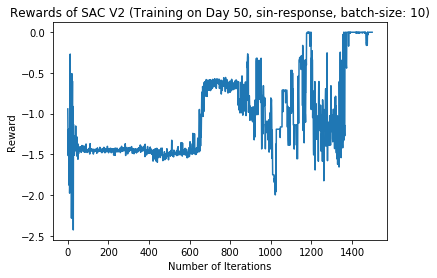

In [106]:
plt.plot(rewards)
plt.title("Rewards of SAC V2 (Training on Day 50, sin-response, batch-size: " + str(batch_size) + ")")
plt.xlabel("Number of Iterations")
plt.ylabel("Reward")

Text(0, 0.5, 'Price')

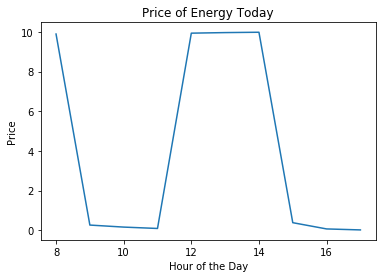

In [107]:
plt.plot([8,9,10,11,12,13,14,15,16,17],action_star)
plt.title("Price of Energy Today")
plt.xlabel("Hour of the Day")
plt.ylabel("Price")

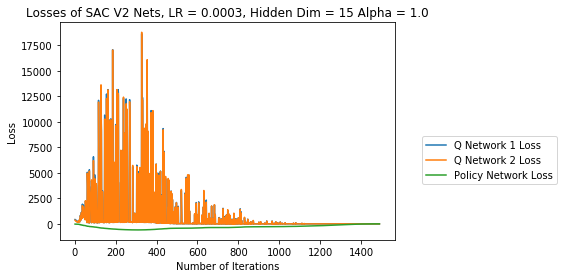

In [108]:
plt.plot(critic_1_losses, label='Q Network 1 Loss')
plt.plot(critic_2_losses, label='Q Network 2 Loss')
plt.plot(policy_losses, label='Policy Network Loss')
title = "Losses of SAC V2 Nets, LR = " + str(LR) + ", Hidden Dim = " + str(H_DIM) + " Alpha = " + str(ALPHA)
plt.title(title)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.5, 0.5))

Text(0.5, 0, 'Number of Training Iterations at a Time Step')

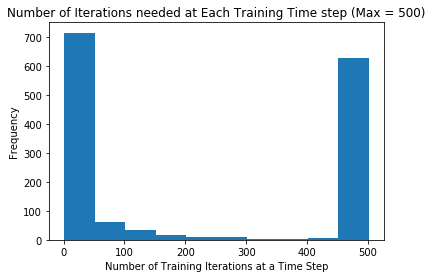

In [109]:
plt.hist(num_iters_list, label='Number of Iterations to Reach Loss')
plt.title("Number of Iterations needed at Each Training Time step (Max = 500)")
plt.ylabel("Frequency")
plt.xlabel("Number of Training Iterations at a Time Step")